# InSituPy demonstration - InSituExperiment
## Background

<div style="display: flex; align-items: center;">
    <img src="./demo_screenshots/experiment_levels.png" height=300 alt="Description" style="margin-right: 10px;">
    <p>In addition to the sample, cellular, and subcellular levels, a spatial transcriptomics dataset typically includes an experiment level that contains information about clinical and experimental cohorts, conditions, or treatments. Most current computational frameworks lack functionalities to incorporate this level into the analysis. To address this, `InSituPy` introduces the `InSituExperiment` class, which manages spatial transcriptomics data and the corresponding metadata of multiple samples simultaneously.</p>
</div>

## Structure

<img src="./demo_screenshots/insituexperiment_structure.png" height=200 alt="Description" style="margin-right: 10px;">

In [1]:
## The following code ensures that all functions and init files are reloaded before executions.
%load_ext autoreload
%autoreload 2

In [ ]:
from pathlib import Path
from insitupy import InSituData, InSituExperiment, CACHE

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Load Xenium data into `InSituData` object

Now the Xenium data can be parsed by providing the data path to the `InSituPy` project folder.

In [4]:
insitupy_project = Path(CACHE / "out/demo_insitupy_project")
xd = InSituData.read(insitupy_project)
xd.load_all(skip="transcripts")
xd

InSituData
Method:		Xenium
Slide ID:	0001879
Sample ID:	Replicate 1
Path:		C:\Users\ge37voy\.cache\InSituPy\out\demo_insitupy_project
Metadata file:	.ispy
    ➤ images
       nuclei:	(25778, 35416)
       CD20:	(25778, 35416)
       HER2:	(25778, 35416)
       HE:	(25778, 35416, 3)
    ➤ cells
       matrix
           AnnData object with n_obs × n_vars = 157600 × 297
           obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_genes_by_counts', 'n_genes', 'leiden', 'cell_type_dc', 'cell_type_tacco', 'cell_type_dc_sub'
           var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
           uns: 'cell_type_dc_colors', 'cell_type_dc_sub', 'cell_type_dc_sub_colors', 'cell_type_tacco_colors', 'counts_location', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
           obsm: 'OT', 'X_pca', 'X_umap', 'annotations', 'ora_est

### Create `InSituExperiment`

<left><img src="./demo_screenshots/insituexperiment_generation.png" height="250"/></left>

*Options to generate an InSituExperiment object*

#### Method 1: Manually add `InSituData` objects

In [5]:
exp = InSituExperiment()
exp.add(
    data=xd,
    metadata={
        "slide_id": xd.slide_id,
        "sample_id": xd.sample_id,
        "patient": "A"
    }
    )

In [6]:
exp

InSituExperiment with 1 samples:
           uid slide_id    sample_id patient
0     389f5b1a  0001879  Replicate 1       A

In the same way also other datasets can be added. For demonstration purposes, we just add the same dataset again and change the metadata.

In [7]:
exp.add(
    data=xd,
    metadata={
        "slide_id": xd.slide_id,
        "sample_id": xd.sample_id,
        "patient": "A",
        "therapy": "drugB"
    }
    )

In [8]:
exp

InSituExperiment with 2 samples:
           uid slide_id    sample_id patient therapy
0     389f5b1a  0001879  Replicate 1       A     NaN
1     c8c3921d  0001879  Replicate 1       A   drugB

#### Method 2: From config file

As config file either a csv file or an excel file can be used.

Example of a valid configuration file:

| directory         | experiment_name | date       | patient    |
|-------------------|-----------------|------------|------------|
| /path/to/dataset1 | Experiment 1    | 2023-09-01 | Patient A  |
| /path/to/dataset2 | Experiment 2    | 2023-09-02 | Patient B  |

In [12]:
import pandas as pd
from insitupy import CACHE

# Define the data
data = {
    "directory": [f"{CACHE}\\out\\demo_insitupy_project", f"{CACHE}\\out\\demo_insitupy_project"],
    "patient": ["A", "B"],
    "therapy": ["drugA", "drugB"]
}

# Create a DataFrame
config_df = pd.DataFrame(data)

# Write the DataFrame to a CSV file
config_df.to_csv('./demo_experiment/insituexperiment_config.csv', index=False)

In [13]:
exp = InSituExperiment.from_config(config_path="./demo_experiment/insituexperiment_config.csv")

100%|██████████| 2/2 [00:00<00:00, 681.34it/s]


In [14]:
exp

InSituExperiment with 2 samples:
           uid slide_id    sample_id patient therapy
0     bc8d73ac  0001879  Replicate 1       A   drugA
1     607a22c5  0001879  Replicate 1       B   drugB

#### Method 3: From regions

We can also use regions from an `InSituData` object to split the data into separate datasets and create an `InSituExperiment` from them. This can be used to select the most interesting regions and focus on them for the analysis or to split a TMA dataset into separate datasets for each core.

In [15]:
exp = InSituExperiment.from_regions(
    data=xd, region_key="TMA"
)

In [16]:
exp

InSituExperiment with 6 samples:
           uid slide_id    sample_id region_key region_name
0     0b3505e3  0001879  Replicate 1        TMA         A-1
1     84782790  0001879  Replicate 1        TMA         A-2
2     1263c84f  0001879  Replicate 1        TMA         A-3
3     a8d7f797  0001879  Replicate 1        TMA         B-1
4     e7c27cf3  0001879  Replicate 1        TMA         B-2
5     39f35786  0001879  Replicate 1        TMA         B-3

In [17]:
# visualize data
viewer = exp.show(3)

Example screenshot of data from one of the cropped cores:

<left><img src="./demo_screenshots/TMA_example.png" height="300"/></left>

## Plot overview of metadata and QC metrics

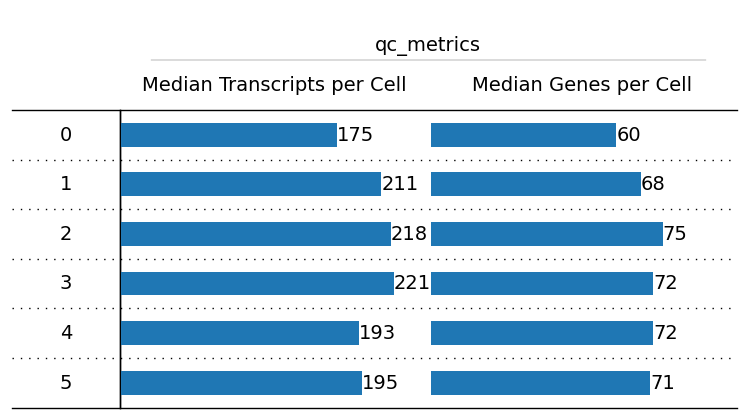

In [18]:
exp.plot_overview()

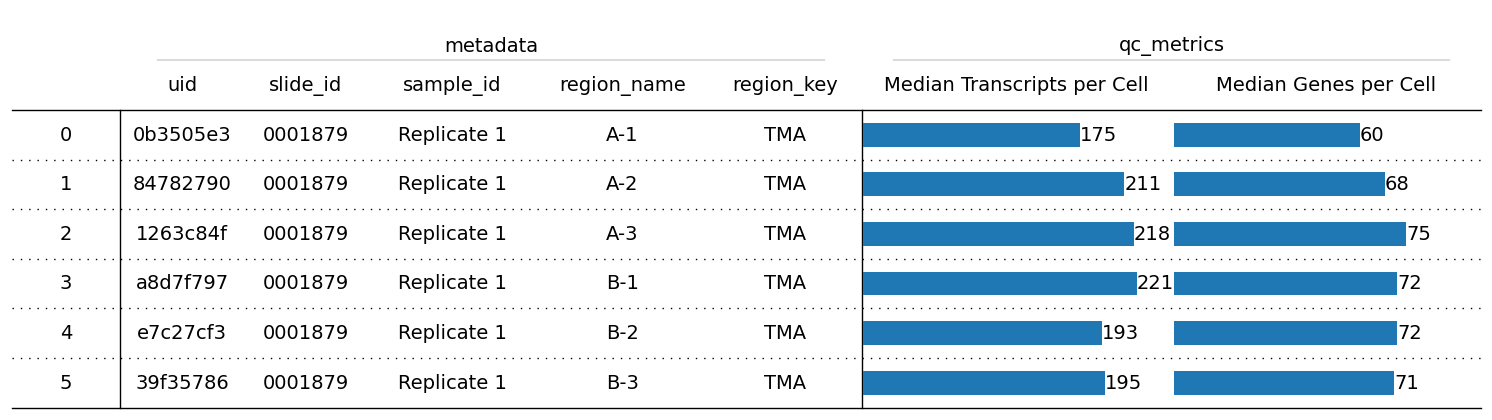

In [19]:
exp.plot_overview(["uid", "slide_id", "sample_id", "region_name", "region_key"], index=True)

## Iterate through `InSituExperiment` using `.iterdata()` method

In [20]:
for metadata, data in exp.iterdata():
    print(f"Metadata:\n{metadata[:3]}\nData:\n{data}")

Metadata:
uid             0b3505e3
slide_id         0001879
sample_id    Replicate 1
Name: 0, dtype: object
Data:
InSituData
Method:		Xenium
Slide ID:	0001879
Sample ID:	Replicate 1
Path:		C:\Users\ge37voy\.cache\InSituPy\out\demo_insitupy_project
Metadata file:	.ispy
    ➤ images
       nuclei:	(4706, 4706)
       CD20:	(4706, 4706)
       HER2:	(4706, 4706)
       HE:	(4706, 4706, 3)
    ➤ cells
       matrix
           AnnData object with n_obs × n_vars = 4878 × 297
           obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_genes_by_counts', 'n_genes', 'leiden', 'cell_type_dc', 'cell_type_tacco', 'cell_type_dc_sub'
           var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
           uns: 'cell_type_dc_colors', 'cell_type_dc_sub', 'cell_type_dc_sub_colors', 'cell_type_tacco_colors', 'counts_location', 'leiden', 'leiden_colors

## Add new metadata

In the following section different scenarios for adding new metadata are shown.

In [21]:
exp1 = InSituExperiment.from_regions(
    data=xd, region_key="demo_regions"
)

In [22]:
exp1

InSituExperiment with 3 samples:
           uid slide_id    sample_id    region_key region_name
0     98910a12  0001879  Replicate 1  demo_regions     Region1
1     b3cf9fa6  0001879  Replicate 1  demo_regions     Region2
2     5a4f87e3  0001879  Replicate 1  demo_regions     Region3

In [23]:
exp2 = exp1.copy()
exp2.append_metadata(
    new_metadata="./demo_experiment/insituexperiment_new_metadata.csv",
    by="region_name", overwrite=True
)

In [24]:
exp2

InSituExperiment with 3 samples:
           uid slide_id    sample_id region_name therapy   organ      test region_key
0     98910a12  0001879  Replicate 1     Region1   drugC   liver  negative       key1
1     b3cf9fa6  0001879  Replicate 1     Region2   drugD    lung      test       key3
2     5a4f87e3  0001879  Replicate 1     Region3   drugE  spleen  positive       key2

In [25]:
exp3 = exp1.copy()
exp3.append_metadata(
    new_metadata="./demo_experiment/insituexperiment_new_metadata.csv",
    by="region_name", overwrite=False
)

In [26]:
exp3

InSituExperiment with 3 samples:
           uid slide_id    sample_id    region_key region_name   organ      test therapy
0     98910a12  0001879  Replicate 1  demo_regions     Region1   liver  negative   drugC
1     b3cf9fa6  0001879  Replicate 1  demo_regions     Region2    lung      test   drugD
2     5a4f87e3  0001879  Replicate 1  demo_regions     Region3  spleen  positive   drugE

In [27]:
exp4 = exp1.copy()
exp4.append_metadata(
    new_metadata="./demo_experiment/insituexperiment_new_metadata2.csv",
    by="region_name", overwrite=False
)

In [28]:
exp4

InSituExperiment with 3 samples:
           uid slide_id    sample_id    region_key region_name   organ      test therapy
0     98910a12  0001879  Replicate 1  demo_regions     Region1   liver  negative   drugC
1     b3cf9fa6  0001879  Replicate 1  demo_regions     Region2     NaN       NaN     NaN
2     5a4f87e3  0001879  Replicate 1  demo_regions     Region3  spleen  positive   drugE

In [29]:
exp5 = exp1.copy()
exp5.append_metadata(
    new_metadata="./demo_experiment/insituexperiment_new_metadata2.csv",
    by="region_name", overwrite=True
)

In [30]:
exp5

InSituExperiment with 3 samples:
           uid slide_id    sample_id region_name therapy   organ      test region_key
0     98910a12  0001879  Replicate 1     Region1   drugC   liver  negative       key1
1     b3cf9fa6  0001879  Replicate 1     Region2     NaN     NaN       NaN        NaN
2     5a4f87e3  0001879  Replicate 1     Region3   drugE  spleen  positive       key2

Concatenate multiple `InSituExperiment` objects

In [31]:
exp

InSituExperiment with 6 samples:
           uid slide_id    sample_id region_key region_name
0     0b3505e3  0001879  Replicate 1        TMA         A-1
1     84782790  0001879  Replicate 1        TMA         A-2
2     1263c84f  0001879  Replicate 1        TMA         A-3
3     a8d7f797  0001879  Replicate 1        TMA         B-1
4     e7c27cf3  0001879  Replicate 1        TMA         B-2
5     39f35786  0001879  Replicate 1        TMA         B-3

In [32]:
exp1

InSituExperiment with 3 samples:
           uid slide_id    sample_id    region_key region_name
0     98910a12  0001879  Replicate 1  demo_regions     Region1
1     b3cf9fa6  0001879  Replicate 1  demo_regions     Region2
2     5a4f87e3  0001879  Replicate 1  demo_regions     Region3

In [33]:
exp_concat = InSituExperiment.concat(
    objs={
        "exp_TMA": exp,
        "exp_demo_regions": exp1
    },
    new_col_name="name"
    )

In [34]:
exp_concat

InSituExperiment with 9 samples:
           uid slide_id    sample_id    region_key region_name            name
0     0b3505e3  0001879  Replicate 1           TMA         A-1         exp_TMA
1     84782790  0001879  Replicate 1           TMA         A-2         exp_TMA
2     1263c84f  0001879  Replicate 1           TMA         A-3         exp_TMA
3     a8d7f797  0001879  Replicate 1           TMA         B-1         exp_TMA
4     e7c27cf3  0001879  Replicate 1           TMA         B-2         exp_TMA
5     39f35786  0001879  Replicate 1           TMA         B-3         exp_TMA
6     98910a12  0001879  Replicate 1  demo_regions     Region1  exp_demo_re...
7     b3cf9fa6  0001879  Replicate 1  demo_regions     Region2  exp_demo_re...
8     5a4f87e3  0001879  Replicate 1  demo_regions     Region3  exp_demo_re...

In [35]:
exp_concat = InSituExperiment.concat(
    objs=[exp, exp1])

In [36]:
exp_concat

InSituExperiment with 9 samples:
           uid slide_id    sample_id    region_key region_name
0     0b3505e3  0001879  Replicate 1           TMA         A-1
1     84782790  0001879  Replicate 1           TMA         A-2
2     1263c84f  0001879  Replicate 1           TMA         A-3
3     a8d7f797  0001879  Replicate 1           TMA         B-1
4     e7c27cf3  0001879  Replicate 1           TMA         B-2
5     39f35786  0001879  Replicate 1           TMA         B-3
6     98910a12  0001879  Replicate 1  demo_regions     Region1
7     b3cf9fa6  0001879  Replicate 1  demo_regions     Region2
8     5a4f87e3  0001879  Replicate 1  demo_regions     Region3

## Indexing and selection of data within `InSituExperiment`

The `InSituExperiment` class allows simple selection and filtering of data using indices or True/False masks.

### Example 1: Select datasets by index

In [37]:
exp_indexed = exp_concat[:3]

In [38]:
exp_indexed

InSituExperiment with 3 samples:
           uid slide_id    sample_id region_key region_name
0     0b3505e3  0001879  Replicate 1        TMA         A-1
1     84782790  0001879  Replicate 1        TMA         A-2
2     1263c84f  0001879  Replicate 1        TMA         A-3

In [39]:
exp_indexed.show(1)

Viewer(camera=Camera(center=(0.0, 499.90625, 499.8), zoom=0.20238794774020127, angles=(0.0, 0.0, 90.0), perspective=0.0, mouse_pan=True, mouse_zoom=True), cursor=Cursor(position=(1.0, 1.0), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=2, ndisplay=2, last_used=0, range=((0.0, 1000.025, 0.2125), (0.0, 999.8125, 0.2125)), current_step=(2352, 2352), order=(0, 1), axis_labels=('0', '1')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'nuclei' at 0x1e277ab0700>, <Image layer 'CD20' at 0x1e292a250d0>, <Image layer 'HER2' at 0x1e29090c3d0>, <Image layer 'HE' at 0x1e28ad24520>], help='use <2> for transform', status='Ready', tooltip=Tooltip(visible=False, text=''), theme='dark', title='0001879: Replicate 1', mouse_over_canvas=False, mouse_move_callbacks=[], mouse_drag_callbacks=[], mouse_double_click_callbacks=[], mouse_wheel_callbacks=[<function dims_scroll at 0x000001E24D407D30>], _persisted_mouse_event={}, _mouse_drag_gen={}, 

### Example 2: Select only datasets with a "1" in the region name

In [40]:
filtering_mask = exp_concat.metadata["region_name"].str.contains("1")
exp_filtered = exp_concat[filtering_mask]

## Save `InSituExperiment`

In [41]:
exp_filtered.saveas(CACHE / "out/test_insituexperiment", overwrite=True)

100%|██████████| 3/3 [00:11<00:00,  3.83s/it]


## Reload `InSituExperiment`

In [42]:
exp_reloaded = InSituExperiment.read(CACHE / "out/test_insituexperiment/")

100%|██████████| 3/3 [00:00<00:00, 1496.54it/s]


In [43]:
exp_reloaded.load_all()

100%|██████████| 3/3 [00:00<00:00,  5.35it/s]


In [44]:
exp_reloaded

InSituExperiment with 3 samples:
           uid  slide_id    sample_id    region_key region_name
0     0b3505e3      1879  Replicate 1           TMA         A-1
1     a8d7f797      1879  Replicate 1           TMA         B-1
2     98910a12      1879  Replicate 1  demo_regions     Region1

In [40]:
exp_reloaded.show(2)

Viewer(camera=Camera(center=(0.0, 286.875, 351.475), zoom=0.5529599532261394, angles=(0.0, 0.0, 90.0), perspective=0.0, mouse_pan=True, mouse_zoom=True), cursor=Cursor(position=(1.0, 1.0), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=2, ndisplay=2, last_used=0, range=((0.0, 573.9625, 0.2125), (0.0, 703.1625, 0.2125)), current_step=(1350, 1654), order=(0, 1), axis_labels=('0', '1')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'nuclei' at 0x23714768b80>, <Image layer 'CD20' at 0x237142c4430>, <Image layer 'HER2' at 0x23717e17ac0>, <Image layer 'HE' at 0x2371c75b160>], help='use <2> for transform', status='Ready', tooltip=Tooltip(visible=False, text=''), theme='dark', title='0001879: Replicate 1', mouse_over_canvas=False, mouse_move_callbacks=[], mouse_drag_callbacks=[], mouse_double_click_callbacks=[], mouse_wheel_callbacks=[<function dims_scroll at 0x0000023682FDEC10>], _persisted_mouse_event={}, _mouse_drag_gen={}, _